In [61]:
from pyedflib import highlevel
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import mne
import pywt
import scaleogram as scg
import firebase_admin
from firebase_admin import credentials

In [ ]:
cred = credentials.Certificate("testlibmuseandroid.json")
firebase_admin.initialize_app(cred,options={'databaseURL': 'https://testlibmuseandroid.firebaseio.com'})

In [124]:
def read_data_from_firebase(user, date):
    from firebase_admin import db
    return db.reference(user + '/' + date + '/EEG_data')

In [155]:
def convert_values(eeg):
    converted = []
    for e in eeg:
        e = [item.replace(",", ".") for item in e]
        e = ''.join(e)
        e = float(e)
        converted.append(e)
    return converted

In [196]:
result = read_data_from_firebase('alicja','Tue Jun 09 00:22:28 GMT+02:00 2020')
eeg1 = convert_values(result.get()['eeg1'])
eeg2 = convert_values(result.get()['eeg2'])
eeg3 = convert_values(result.get()['eeg3'])
eeg4 = convert_values(result.get()['eeg4'])

# eeg1 = convert_values(result.get()['af7'])
# eeg2 = convert_values(result.get()['af8'])
# eeg3 = convert_values(result.get()['tp9'])
# eeg4 = convert_values(result.get()['tp10'])

In [198]:
def write_to_edf(eeg1, eeg2, eeg3, eeg4, patient_name, file_name):
    channel_names = ['TP9', 'AF7', 'AF8', 'TP10']
    signals = np.array([eeg1, eeg2, eeg3, eeg4])
    signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=256)
    header = highlevel.make_header(patientname=patient_name)
    highlevel.write_edf(file_name +'.edf', signals, signal_headers, header)

In [199]:
write_to_edf(eeg1,eeg2,eeg3,eeg4,'alicja','edfalicja')

In [200]:
raw = mne.io.read_raw_edf("edfalicja.edf",preload=True)
raw.info

Extracting EDF parameters from C:\Users\alicj\PYTHON\edfalicja.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535  =      0.000 ...     5.996 secs...


<Info | 7 non-empty values
 bads: []
 ch_names: TP9, AF7, AF8, TP10
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2020-06-09 00:25:59 UTC
 nchan: 4
 projs: []
 sfreq: 256.0 Hz
>

Effective window size : 6.000 (s)


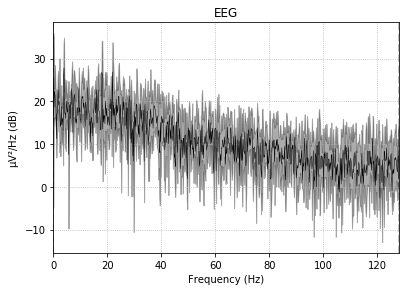

In [201]:
def add_arrows(axes):
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (50):
            idx = np.searchsorted(freqs, freq)
            y = psds[(idx - 4):(idx + 5)].max()
            ax.arrow(x=freqs[idx], y=y + 18, dx=0, dy=-12, color='red', width=0.1, head_width=3, length_includes_head=True)


fig = raw.plot_psd(fmax=128, average=True)

In [173]:
def apply_notch_and_plot(raw):
    freqs = (50, 100)
    raw_notch = raw.copy().notch_filter(freqs=freqs)
    for title, data in zip(['Unfiltered', 'Notch applied'], [raw, raw_notch]):
        fig = data.plot_psd(fmax=128, average=True)
        fig.suptitle(title)
    return raw_notch

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 sec)

Effective window size : 6.000 (s)


<ipython-input-173-b655bea4f48c>:3: RuntimeWarning: filter_length (1691) is longer than the signal (1536), distortion is likely. Reduce filter length or filter a longer signal.
  raw_notch = raw.copy().notch_filter(freqs=freqs)


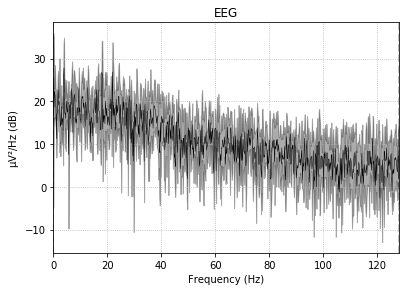

Effective window size : 6.000 (s)


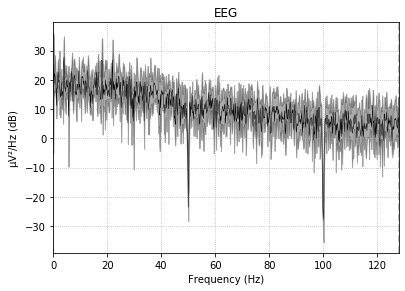

In [202]:
raw_notch = apply_notch_and_plot(raw)

In [176]:
def visualize(raw):
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(ch_names=raw.info['ch_names'], sfreq=raw.info['sfreq'], ch_types='eeg')
    info.set_montage(montage)
    raw.info = info

    raw.set_montage('standard_1020')
    mne.set_eeg_reference(raw, ref_channels='average')
    data = raw.get_data()
    eegCut = data[:,300]
    mne.viz.plot_topomap(eegCut, raw.info, vmin=None, vmax=None)
    #cmap='Pastel1'

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


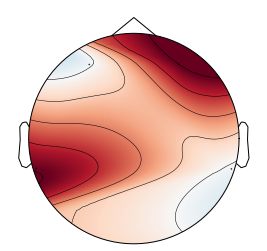

In [177]:
#visualize(raw)
visualize(raw_notch)

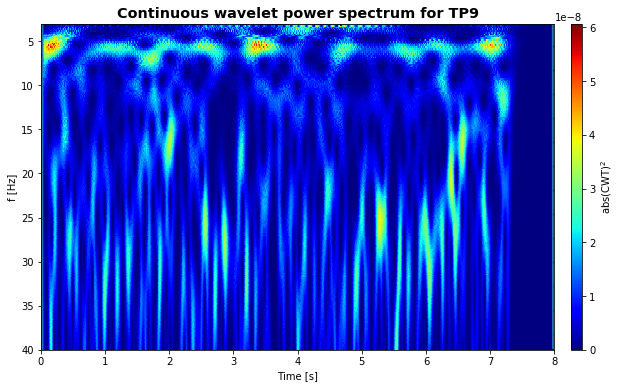

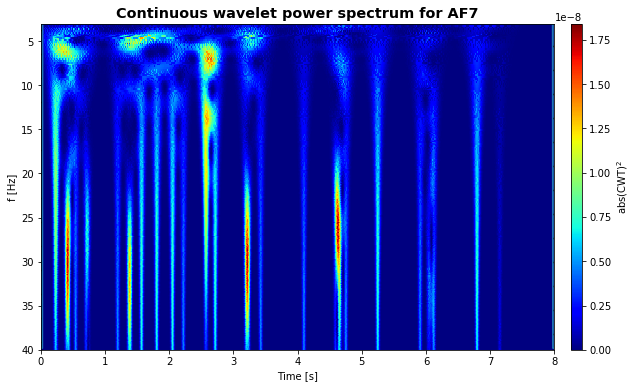

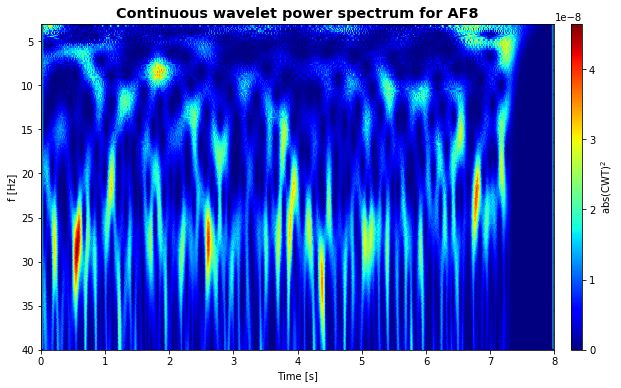

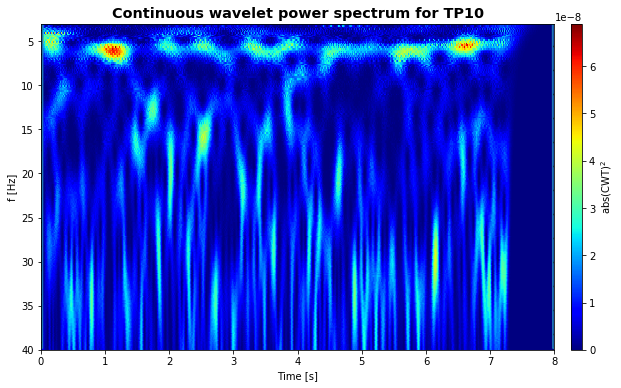

In [178]:
sfreq = raw.info['sfreq']

#fa=fc*sfreq/a
#a=fc*sfreq/fa

wavelet='cmor0.8-1.5'
fa = np.arange(3, 40, 0.2)
dt = 1/sfreq
a = pywt.central_frequency(wavelet)/(dt * fa)

data, times = raw_notch[:, :]

for i in range(len(data)):
    ax = scg.cws(times, data[i,:], scales=a, wavelet=wavelet, yaxis='frequency',spectrum='power', ylabel="f [Hz]", xlabel="Time [s]",yscale='linear', figsize=(10,6))
    ax.set_title('Continuous wavelet power spectrum for ' + raw.info['ch_names'][i], weight='bold',size='x-large')

In [179]:
epochs = mne.make_fixed_length_epochs(raw_notch)

8 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [180]:
frequencies = np.arange(7, 40, 0.5)
power = mne.time_frequency.tfr_morlet(epochs, n_cycles=frequencies/2.,  return_itc=False,
                                      freqs=frequencies, decim=4)

Loading data for 8 events and 256 original time points ...
0 bad epochs dropped


Applying baseline correction (mode: mean)


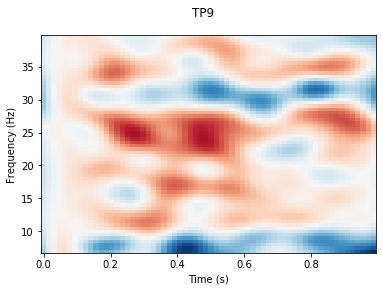

Applying baseline correction (mode: mean)


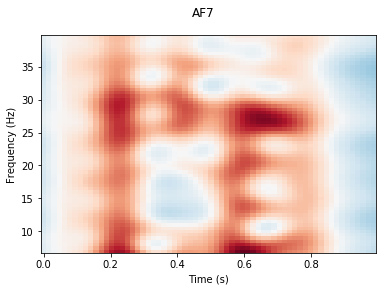

Applying baseline correction (mode: mean)


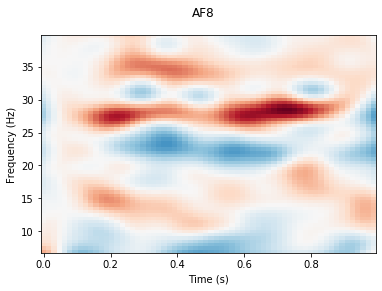

Applying baseline correction (mode: mean)


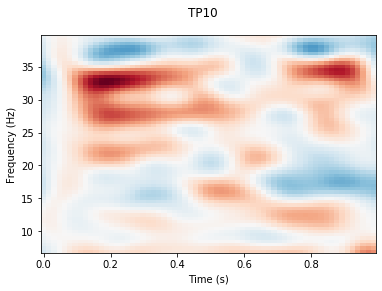

ValueError: All picks must be < n_channels (4), got [4]

In [181]:
for i in range(len(epochs)):
    power.plot([i], baseline=(0., 0.1), mode='mean',colorbar=False)

In [182]:
def visualize_tfr(power):
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(ch_names=power.info['ch_names'], sfreq=power.info['sfreq'], ch_types='eeg')
    info.set_montage(montage)
    power.info = info
    mne.viz.plot_tfr_topomap(power, ch_type='eeg', mode='mean')

No baseline correction applied


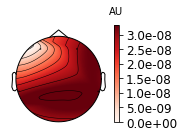

In [183]:
visualize_tfr(power)

Loading data for 8 events and 256 original time points ...
Applying baseline correction (mode: mean)
Loading data for 8 events and 256 original time points ...
Applying baseline correction (mode: mean)
Loading data for 8 events and 256 original time points ...
Applying baseline correction (mode: mean)


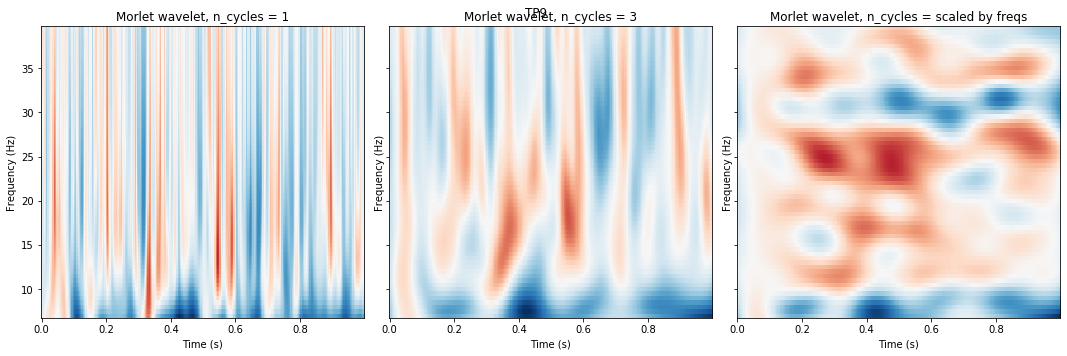

In [184]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
all_n_cycles = [1, 3, frequencies / 2.]
for n_cycles, ax in zip(all_n_cycles, axs):
    power = mne.time_frequency.tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, return_itc=False)
    power.plot([0], baseline=(0., 0.1), mode='mean', axes=ax, show=False, colorbar=False)
    n_cycles = 'scaled by freqs' if not isinstance(n_cycles, int) else n_cycles
    ax.set_title('Morlet wavelet, n_cycles = %s' % n_cycles)

plt.tight_layout()